In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import yfinance as yf

In [2]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Load the stock price data
df = pd.read_csv('../data/AAPL.csv', index_col='Date', parse_dates=True)
df.sort_index(inplace=True)

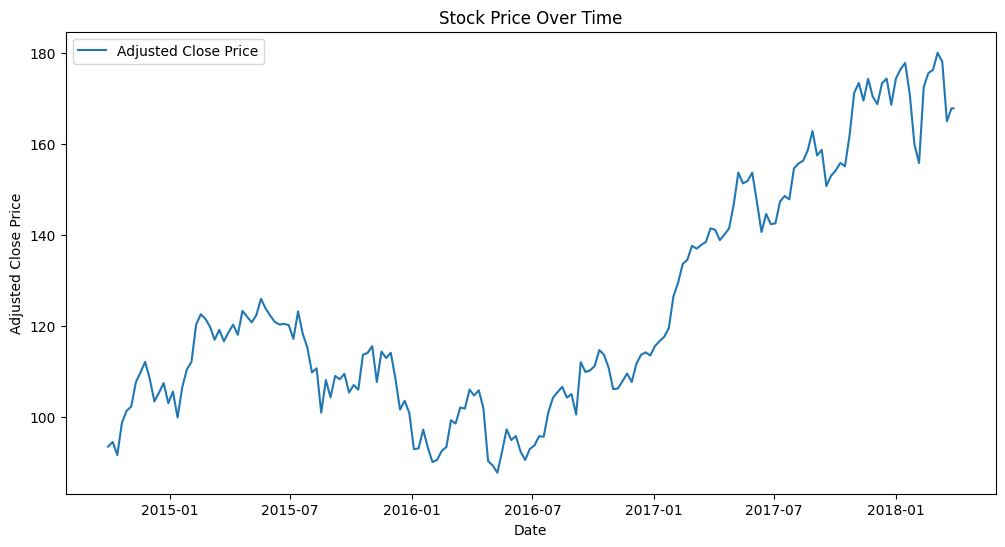

In [4]:
# --- Data Exploration and Visualization ---
plt.figure(figsize=(12, 6))
plt.plot(df['Adj Close'], label='Adjusted Close Price')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

In [5]:
# --- Feature Engineering ---
# Example: Simple Moving Average
df['SMA_30'] = df['Adj Close'].rolling(window=30).mean()
df.dropna(inplace=True)

In [6]:
# --- Sentiment Data Integration (If you have sentiment_data.csv) ---
# sentiment_df = pd.read_csv('../data/sentiment_data.csv', index_col='Date', parse_dates=True)
# df = df.merge(sentiment_df, on='Date', how='left')
# df.fillna(method='ffill', inplace=True)

# Prepare data for LSTM
data = df.values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [7]:
# Define sequence length for LSTM
sequence_length = 60

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1]) # All columns except the target (Adj Close)
        y.append(data[i+seq_length, 3])    # Target is the 'Adj Close' which is the 4th column (index 3) after scaling
    return np.array(X), np.array(y)


In [8]:
X, y = create_sequences(scaled_data, sequence_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

In [9]:
# Create DataLoader for efficient batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False) # No need to shuffle time series

In [10]:
# --- Build the Optimized Deep Learning Model (LSTM with PyTorch) ---
class StockPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :]) # Take the output of the last time step
        out = self.fc(out)
        return out


In [11]:
# Instantiate the model
input_size = X_train.shape[2]
hidden_size = 100
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 50

model = StockPriceLSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# --- Train the Model ---
history = {'loss': [], 'val_loss': []}
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    train_loss /= len(train_loader.dataset)
    history['loss'].append(train_loss)

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()
        history['val_loss'].append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/50], Train Loss: 0.2740, Val Loss: 0.6382
Epoch [2/50], Train Loss: 0.1697, Val Loss: 0.3911
Epoch [3/50], Train Loss: 0.0684, Val Loss: 0.1077
Epoch [4/50], Train Loss: 0.0184, Val Loss: 0.0159
Epoch [5/50], Train Loss: 0.0777, Val Loss: 0.0054
Epoch [6/50], Train Loss: 0.0488, Val Loss: 0.0507
Epoch [7/50], Train Loss: 0.0353, Val Loss: 0.0862
Epoch [8/50], Train Loss: 0.0303, Val Loss: 0.0724
Epoch [9/50], Train Loss: 0.0268, Val Loss: 0.0305
Epoch [10/50], Train Loss: 0.0181, Val Loss: 0.0057
Epoch [11/50], Train Loss: 0.0275, Val Loss: 0.0094
Epoch [12/50], Train Loss: 0.0218, Val Loss: 0.0061
Epoch [13/50], Train Loss: 0.0164, Val Loss: 0.0135
Epoch [14/50], Train Loss: 0.0151, Val Loss: 0.0112
Epoch [15/50], Train Loss: 0.0097, Val Loss: 0.0072
Epoch [16/50], Train Loss: 0.0091, Val Loss: 0.0207
Epoch [17/50], Train Loss: 0.0084, Val Loss: 0.0128
Epoch [18/50], Train Loss: 0.0098, Val Loss: 0.0068
Epoch [19/50], Train Loss: 0.0066, Val Loss: 0.0085
Epoch [20/50], Train 

In [13]:
# --- Evaluate the Model ---
model.eval()
with torch.no_grad():
    predicted_scaled_prices = model(X_test_tensor).cpu().numpy()

# Inverse transform the predictions
# Create a dummy array with the same number of features as the training data
dummy_array = np.zeros((len(predicted_scaled_prices), data.shape[1]))
dummy_array[:, 3] = predicted_scaled_prices.flatten() # Place the predicted scaled price in the 'Adj Close' column
predicted_prices = scaler.inverse_transform(dummy_array)[:, 3]

dummy_actual = np.zeros((len(y_test_tensor), data.shape[1]))
dummy_actual[:, 3] = y_test_tensor.cpu().numpy().flatten()
actual_prices = scaler.inverse_transform(dummy_actual)[:, 3]

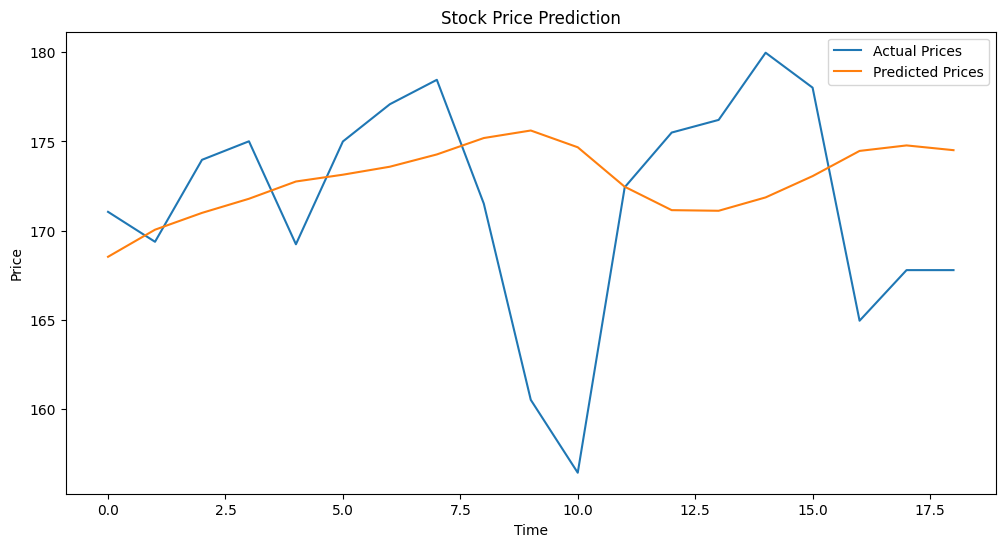

In [14]:
# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [15]:

# Calculate Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 7.137869775604545


In [16]:
# --- Save the Trained Model and Scaler ---
torch.save(model.state_dict(), '../templates/model.pth')
import joblib
joblib.dump(scaler, '../templates/scaler.pkl')

['../templates/scaler.pkl']